In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bin import utils

In [2]:
sc_data = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/RNA/sc.reclustered.h5')
st_data = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/RNA/reclustered.h5')

gdata = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/RNA/spatial.combined.bin100.h5')
gdata = gdata[:, gdata.var_names.str.startswith('sg')].copy()
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [3]:
gdata = gdata[st_data.obs_names, :].copy()

In [4]:
t_genes = pd.read_csv('/home/wpy/stereoseq/20240702-Exclusive/t_genes.txt', header=None)
t_genes = t_genes[0].tolist()

In [11]:
t_genes = np.intersect1d(np.intersect1d(t_genes, sc_data.var_names), st_data.var_names)

sc_expr = sc_data[sc_data.obs['perturb_gene'] == 'sgBatf', t_genes].copy()
st_expr = st_data[gdata[:, 'sgBatf'].X.toarray() > 0, t_genes].copy()

sc_expr.obs['source'] = 'sc'
st_expr.obs['source'] = 'st'

merge_data = sc.concat([sc_expr, st_expr])

In [13]:
sc.pp.pca(merge_data)
sc.external.pp.harmony_integrate(merge_data, key='source')

2025-01-10 15:27:59,915 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-10 15:28:02,739 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-10 15:28:02,742 - harmonypy - INFO - Iteration 1 of 10
2025-01-10 15:28:02,827 - harmonypy - INFO - Iteration 2 of 10
2025-01-10 15:28:02,976 - harmonypy - INFO - Converged after 2 iterations


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


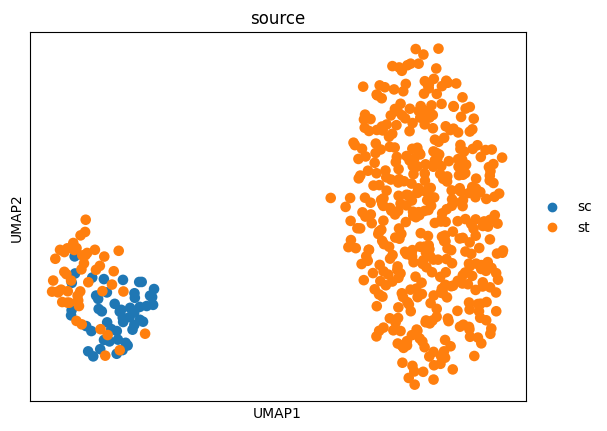

In [16]:
sc.pp.neighbors(merge_data, use_rep='X_pca_harmony')
sc.tl.umap(merge_data)
sc.pl.umap(merge_data, color='source')